## MVA 2022-23 - TP3

Documentation for the latest version of Gudhi: 

http://gudhi.gforge.inria.fr/python/latest/

# Sensor data

Download the data at the following address: http://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat, save it as a file named [data_acc.dat](http://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/data_acc.dat), and load it using the pickle module:

In [1]:
import numpy as np
import pickle as pickle
import gudhi as gd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
from sklearn import manifold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

f = open("data_acc.dat","rb")
data = pickle.load(f,encoding="latin1")
f.close()
data_A = data[0]
data_B = data[1]
data_C = data[2]
label = data[3]



#%matplotlib inline
%matplotlib notebook

The walk of 3 persons A, B and C has been recorded using the accelerometer sensor of a smartphone in their pocket, giving rise to 3 multivariate time series in $\mathbb{R}^3$: each time series represents the 3 coordinates of the acceleration of the corresponding person in a coordinate system attached to the sensor (take care that, as the smartphone was carried in a possibly different position for each person, these time series cannot be compared coordinates by coordinates). Using a sliding window, each series has been split in a list of 100 time series made of 200 consecutive points, that are now stored in data_A, data_B and data_C.

* Plot a few of the time series to get an idea of the corresponding point clouds in $\mathbb{R}^3$. For example:

<IPython.core.display.Javascript object>


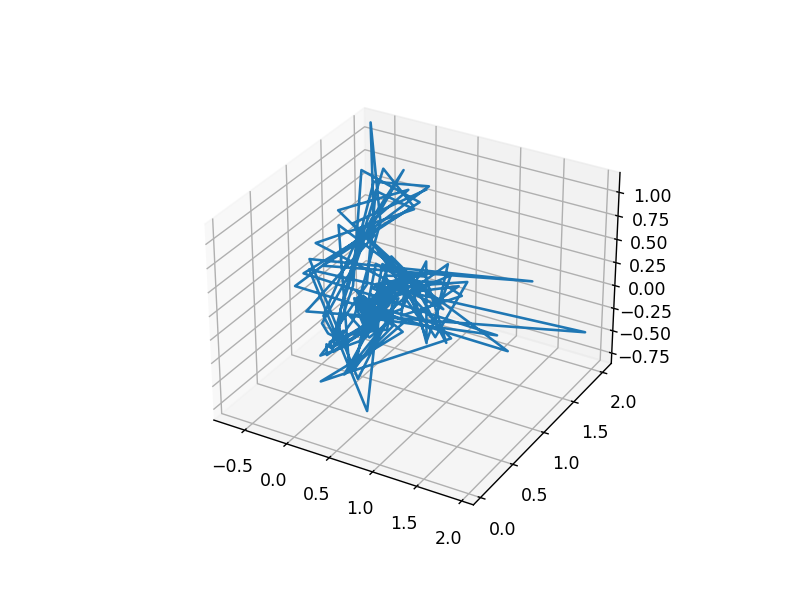

C:\Users\chaza\anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


In [2]:
data_A_sample = data_A[0]
plt.gca(projection='3d')
plt.plot(data_A_sample [:,0],data_A_sample [:,1],data_A_sample [:,2])

* Compute and plot the persistence diagrams of the alpha-complex filtrations, for a few examples of the time series.

In [3]:
data_ABC = np.concatenate((data_A,data_B,data_C),axis=0)
nb_data = np.shape(data_ABC)[0]

#Compute all persistence diagrams
diag_list = []
diag_list_dim0 = []
diag_list_dim1 = []
for i in range(nb_data):
    pt_cloud = data_ABC[i,:,:]
    alpha_complex = gd.AlphaComplex(points=pt_cloud)
    st = alpha_complex.create_simplex_tree()
    diag = st.persistence()
    diag_list.append(diag)
    diag_list_dim0.append(st.persistence_intervals_in_dimension(0))
    diag_list_dim1.append(st.persistence_intervals_in_dimension(1))
    if i%30 == 0:
        print('number of computed diagrams:', i)

number of computed diagrams: 0
number of computed diagrams: 30
number of computed diagrams: 60
number of computed diagrams: 90
number of computed diagrams: 120
number of computed diagrams: 150
number of computed diagrams: 180
number of computed diagrams: 210
number of computed diagrams: 240
number of computed diagrams: 270


<IPython.core.display.Javascript object>


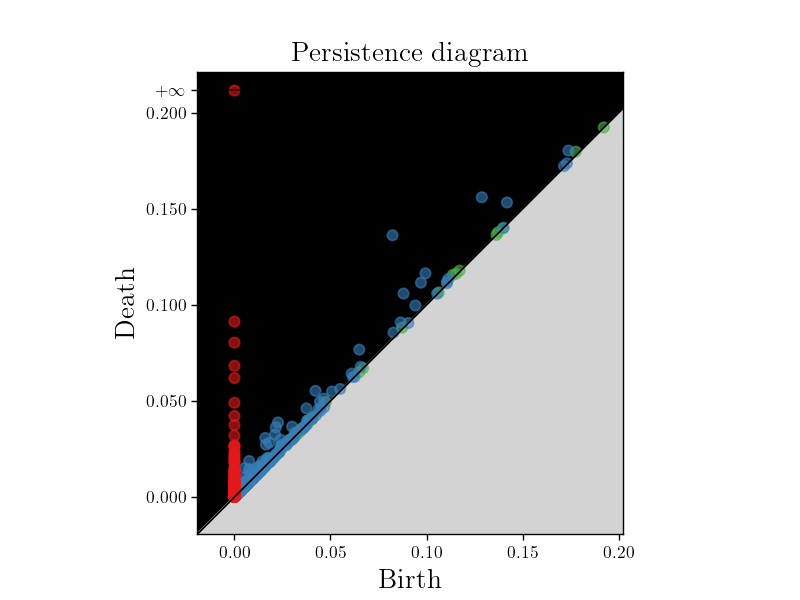

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [4]:
gd.plot_persistence_diagram(diag_list[25])

* Compute the 0-dimensional and 1-dimensional persistence diagrams (α-shape or Rips-Vietoris filtration) of all the time series. Compute the matrix of pairwise distances between the diagrams (as this may take a while, you can just select a subset of all the diagrams where each of the 3 classes A, B and C are represented). Visualize the pairwise distances via Multidimensional Scaling (use a different color for each class). You can use sklearn for that (B1 denotes the matrix of pairewise distances):

In [ ]:
#Compute pairwise distance matrices - Be careful that if you compute it for all the data, it may take a few minutes
B0= np.zeros((nb_data,nb_data))
B1 =np.zeros((nb_data,nb_data))

for i in range(nb_data):
    for j in range(i):
        B0[i,j] = gd.bottleneck_distance(diag_list_dim0[i], diag_list_dim0[j])
        B1[i,j] = gd.bottleneck_distance(diag_list_dim1[i], diag_list_dim1[j])
    if i%10 == 0:
        print('number of rows computed:', i)

In [ ]:
#Save the pairwise distance matrices
B0 = B0 + B0.transpose()
B1 = B1 + B1.transpose()

pickle.dump(B0, open("B0.dat", "wb"))
pickle.dump(B1, open("B1.dat", "wb"))

In [7]:
#To load the pairwise distance matrices 
B0 = pickle.load(open("B0.dat", "rb"), encoding="latin1")
B1 = pickle.load(open("B1.dat", "rb"), encoding="latin1")

In [8]:
#plt.imshow(B0, cmap='gray', interpolation='nearest');
plt.imshow(B1, cmap='gray', interpolation='nearest');

<IPython.core.display.Javascript object>


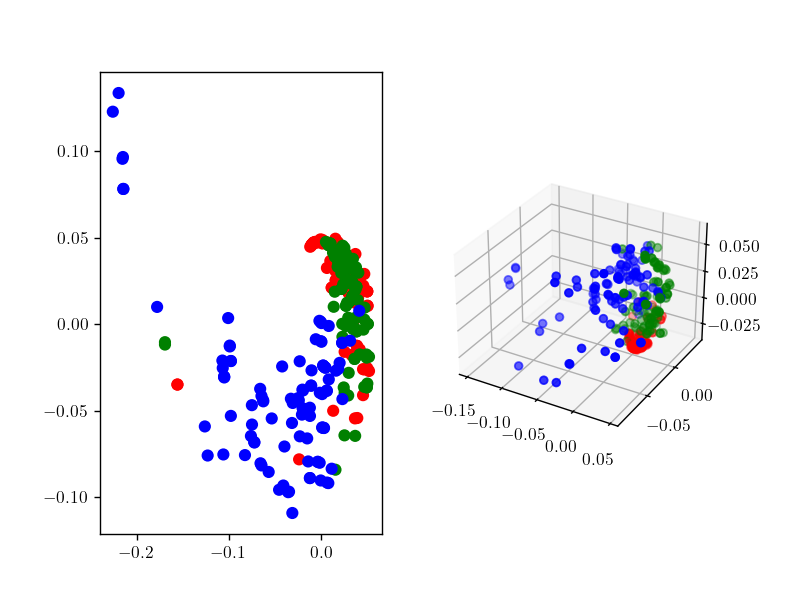

In [9]:
# B is the pairwise distance matrix between 0 or 1-dim dgms
#label_color contains the colors corresponding to the class of each dgm

colors = ("red","green","blue","black","purple","cyan")
label_color = []
for i in range(100):
    label_color.append(colors[0])
for i in range(100):
    label_color.append(colors[1])
for i in range(100):
    label_color.append(colors[2])

    
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos0 = mds.fit(B0).embedding_
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(pos0[:,0], pos0[:, 1], marker = 'o', color=label_color)

mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos1 = mds.fit(B1).embedding_
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pos1[:,0], pos1[:, 1], pos1[:,2], marker = 'o', color=label_color)    

* Use the function below to embed the data in dimension 3×3 = 9 with a delay equal to 2 (time-delay embedding) and do the same experiments as previously, using the Vietoris-Rips filtration this time.

In [10]:
def sliding_window_data(x,edim,delay=1):
    """time delay embedding of a d-dim times series into R^{d*edim}
    the time series is assumed to be periodic
    parameters:
        + x: a list of d lists of same length L or a dxL numpy array
        + edim: the number of points taken to build the embedding in R^{d*edim}
        + delay: embeeding given by (x[i],x[i+delay],...,x[i + (edim-1)*delay])
            Default value for delay is 1
    """
    ts = np.asarray(x)
    if len(np.shape(ts)) == 1:
        ts = np.reshape(ts,(1,ts.shape[0]))
    ts_d = ts.shape[0]
    ts_length = ts.shape[1]
    #output = zeros((edim*ts_d,nb_pt))
    output = ts
    for i in range(edim-1):
        output = np.concatenate((output,np.roll(ts,-(i+1)*delay,axis=1)),axis=0)
    return output

In [ ]:
edim=3
delay=2
diag_list = []
diag_list_TD_dim0 = []
diag_list_TD_dim1 = []
for i in range(nb_data):
    pt_cloud = sliding_window_data(np.transpose(data_ABC[i,:,:]),edim,delay)
    pt_cloud = np.transpose(pt_cloud)
    rips_complex = gd.RipsComplex(pt_cloud,max_edge_length=100.0)
    st = rips_complex.create_simplex_tree(max_dimension=2)
    diag_list.append(st.persistence())
    diag_list_TD_dim0.append(st.persistence_intervals_in_dimension(0))
    diag_list_TD_dim1.append(st.persistence_intervals_in_dimension(1))
    if i%10 == 0:
        print('number of computed diagrams:', i)

You can also use the Gudhi utility TimeDelayEmbedding (see Point Cloud Utilities manual https://gudhi.inria.fr/python/latest/point_cloud.html)

In [11]:
from gudhi.point_cloud.timedelay import TimeDelayEmbedding

edim=3
delay=2
diag_list = []
diag_list_TD_dim0 = []
diag_list_TD_dim1 = []

for i in range(nb_data):
    pt_cloud = TimeDelayEmbedding(dim=9,delay=1, skip=1)(data_ABC[i,:,:])
    rips_complex = gd.RipsComplex(pt_cloud,max_edge_length=100.0)
    st = rips_complex.create_simplex_tree(max_dimension=2)
    diag_list.append(st.persistence())
    diag_list_TD_dim0.append(st.persistence_intervals_in_dimension(0))
    diag_list_TD_dim1.append(st.persistence_intervals_in_dimension(1))
    if i%10 == 0:
        print('number of computed diagrams:', i)

number of computed diagrams: 0
number of computed diagrams: 10
number of computed diagrams: 20
number of computed diagrams: 30
number of computed diagrams: 40
number of computed diagrams: 50
number of computed diagrams: 60
number of computed diagrams: 70
number of computed diagrams: 80
number of computed diagrams: 90
number of computed diagrams: 100
number of computed diagrams: 110
number of computed diagrams: 120
number of computed diagrams: 130
number of computed diagrams: 140
number of computed diagrams: 150
number of computed diagrams: 160
number of computed diagrams: 170
number of computed diagrams: 180
number of computed diagrams: 190
number of computed diagrams: 200
number of computed diagrams: 210
number of computed diagrams: 220
number of computed diagrams: 230
number of computed diagrams: 240
number of computed diagrams: 250
number of computed diagrams: 260
number of computed diagrams: 270
number of computed diagrams: 280
number of computed diagrams: 290


In [12]:
pickle.dump(diag_list, open("Diags_accelero.dat", "wb"))
pickle.dump(diag_list_TD_dim0, open("Diags_accelero_TD0.dat", "wb"))
pickle.dump(diag_list_TD_dim1, open("Diags_accelero_TD1.dat", "wb"))

In [ ]:
B_TD_0= np.zeros((nb_data,nb_data))
B_TD_1 =np.zeros((nb_data,nb_data))

for i in range(nb_data):
    for j in range(i):
        B_TD_0[i,j] = gd.bottleneck_distance(diag_list_TD_dim0[i], diag_list_TD_dim0[j])
        B_TD_1[i,j] = gd.bottleneck_distance(diag_list_TD_dim1[i], diag_list_TD_dim1[j])
    if i%10 == 0:
        print('number of rows computed:',i)

In [ ]:
B_TD_0 = B_TD_0 + B_TD_0.transpose()
B_TD_1 = B_TD_1 + B_TD_1.transpose()

pickle.dump(B_TD_0, open("B_TD_0.dat", "wb")) 
pickle.dump(B_TD_1, open("B_TD_1.dat", "wb"))

In [13]:
#To load pairwise distance matrices 
B_TD_0 = pickle.load(open("B_TD_0.dat", "rb"), encoding="latin1") 
B_TD_1 = pickle.load(open("B_TD_1.dat", "rb"), encoding="latin1")

<IPython.core.display.Javascript object>


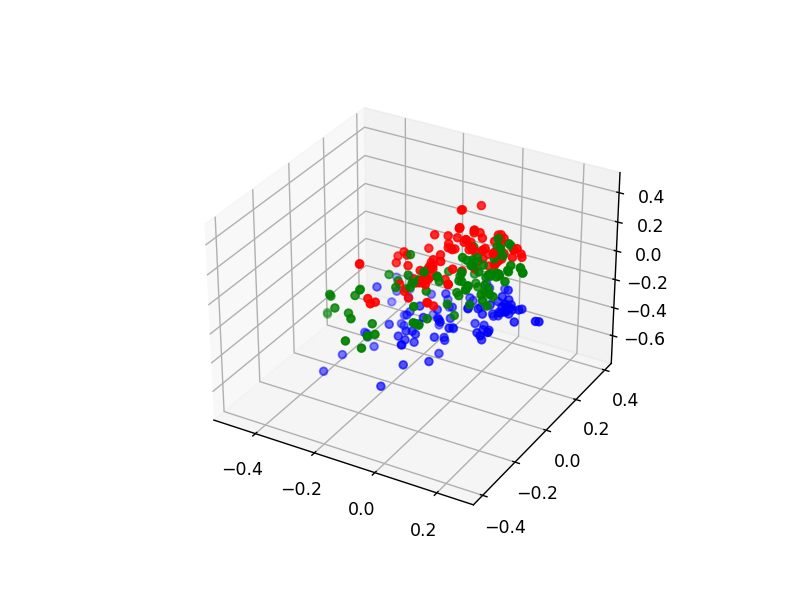

In [10]:
mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos0 = mds.fit(B_TD_0).embedding_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos0[:,0], pos0[:, 1], pos0[:,2], marker = 'o', color=label_color)

In [ ]:
mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos1 = mds.fit(B_TD_1).embedding_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos1[:,0], pos1[:, 1], pos1[:,2], marker = 'o', color=label_color)

# Persistence landscapes

Landscape construction is also available in Gudhi. Here is a simple python implementation you can use for this class.

In [ ]:
def landscapes_approx(diag,p_dim,x_min,x_max,nb_nodes,nb_ld):
    """Compute a dicretization of the first nb_ld landscape of a 
    p_dim-dimensional persistence diagram on a regular grid on the 
    interval [x_min,x_max]. The output is a nb_ld x nb_nodes numpy
    array
    + diag: a persistence diagram (in the Gudhi format)
    + p_dim: the dimension in homology to consider
    """
    landscape = np.zeros((nb_ld,nb_nodes))
    diag_dim = []
    for pair in diag: #get persistence points for homology in dimension dim
        if (pair[0] == p_dim):
            diag_dim.append(pair[1])

    step = (x_max - x_min) / (nb_nodes - 1)
    #Warning: naive and not the most efficient way to proceed!!!!!
    for i in range(nb_nodes):
        x = x_min + i * step
        t = x / np.sqrt(2)
        event_list = []
        for pair in diag_dim:
            b = pair[0]
            d = pair[1]
            if b <= t <= d:
                if t >= (d+b)/2:
                    event_list.append((d-t)*np.sqrt(2))
                else:
                    event_list.append((t-b)*np.sqrt(2))
        event_list.sort(reverse=True)
        event_list = np.asarray(event_list)
        for j in range(nb_ld):
            if(j<len(event_list)):
                landscape[j,i]=event_list[j]

    return landscape


You can (and should) also use the landscape implemented in Gudhi : Representation manual ( https://gudhi.inria.fr/python/latest/representations.html )

In [14]:
from gudhi.representations import Landscape 

* Test the function on a few examples of diagrams and plot the resulting landscapes.

In [15]:
diag_list=pickle.load(open("Diags_accelero.dat", "rb"))
diag_list0=pickle.load(open("Diags_accelero_TD0.dat","rb"))
diag_list1=pickle.load(open("Diags_accelero_TD1.dat","rb"))

<IPython.core.display.Javascript object>


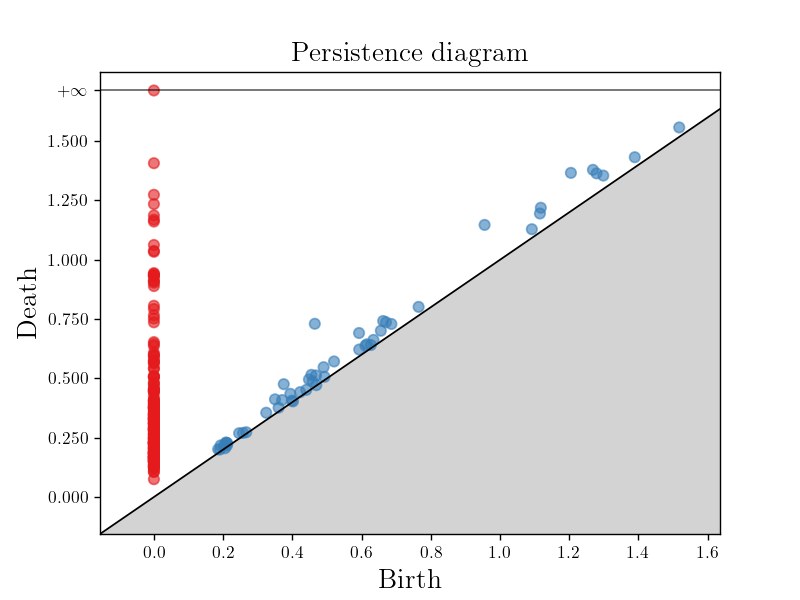

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [16]:
gd.plot_persistence_diagram(diag_list[1])

In [17]:
# Example of parameters, you don't have to use those
nb_ld = 5 # number of Landscapes 
nb_nodes = 500
length_max = 1.0

* Compute and store the persistence landscapes of the accelerometer time series. Use the obtained landscapes to experiment with supervised and non supervised classification on this data.

In [18]:
# Example of parameters, you don't have to use those
nb_ld = 5 # number of Landscapes 
nb_nodes = 100
range_ld = [0.0,1.0]

L0=Landscape(num_landscapes=nb_ld, resolution=nb_nodes, sample_range=range_ld).fit_transform(diag_list0)
L1=Landscape(num_landscapes=nb_ld, resolution=nb_nodes, sample_range=range_ld).fit_transform(diag_list1)

<IPython.core.display.Javascript object>


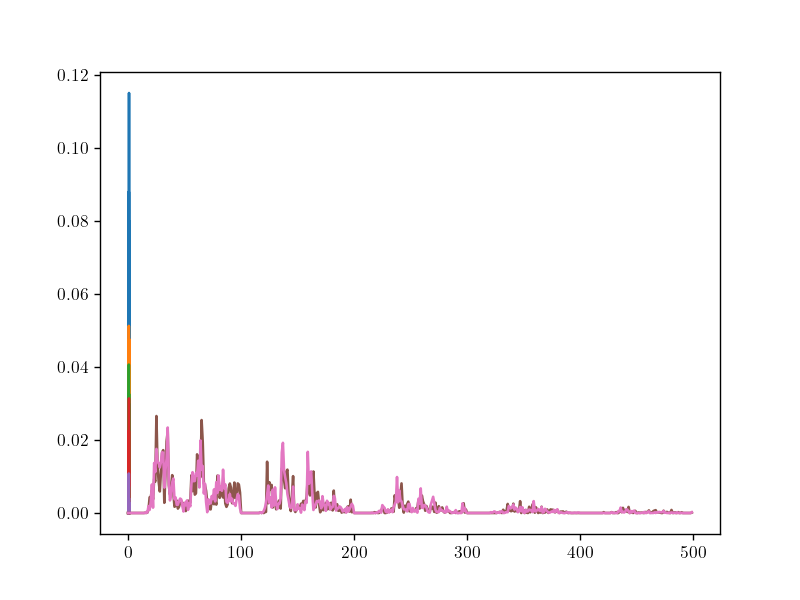

In [20]:
#plot one of the landscapes
l = np.reshape(L1[28,:],(nb_ld,nb_nodes))
t = np.linspace(0.0, 1.0, num=nb_nodes)
plt.figure()
for i in range(nb_ld): 
    plt.plot(t,l[i,:])
plt.show()

Use the landscapes as features to train a classifier (classes A, B and C)

0.95
0.9833333333333333
0.9833333333333333
0.9333333333333333
1.0
1.0
0.9666666666666667
0.9666666666666667
0.9833333333333333
0.9166666666666666
1.0
1.0
0.9333333333333333
0.95
1.0
0.9666666666666667
0.9833333333333333
0.9833333333333333
0.9833333333333333
0.9666666666666667
avg pred:  0.9724999999999999


<IPython.core.display.Javascript object>


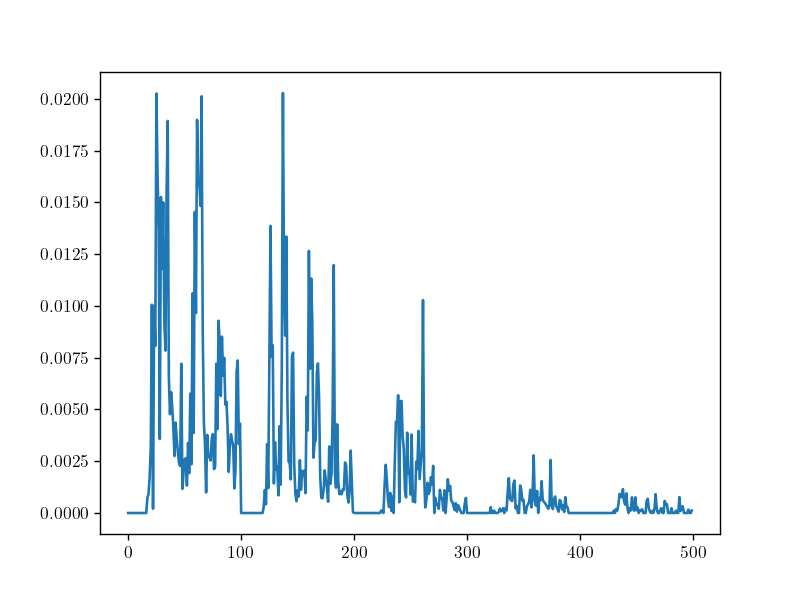

In [24]:
# Classification with random forests 
# Interesting compare with L0_list, L1_list and L_list
avg = 0
for i in range(20):
    L_train, L_test, label_train, label_test = train_test_split(L1, label, test_size=0.2)
    RF = RandomForestClassifier()
    RF.fit(L_train, label_train)
    print(np.mean(RF.predict(L_test) == label_test) )
    avg += np.mean(RF.predict(L_test) == label_test)
    #print(confusion_matrix(RF.predict(L_test), label_test))
print ("avg pred: ",avg/20)

plt.figure()
plt.plot(RF.feature_importances_)
plt.show()

Do the same exercise with other representations of persistence (e.g. persistence images)

# Classification of orbits of dynamical systems

The goal of this exercise is to classify sequences of points (orbits) generated by different dynamical systems. Given some initial position $(x_0, y_0) \in [0,1]^2$ and a parameter $r > 0$, we generate a 2D point cloud $(x_n,y_n)_{n = 1, \dots, N}$ following:

\begin{align}
	\begin{cases}
		x_{n+1} = x_n + r y_n (1 - y_n) 		&\text{ mod } 1 \\
		y_{n+1} = y_n + r x_{n+1} (1 - x_{n+1}) &\text{ mod } 1		
	\end{cases}
\end{align}

The orbits of this dynamical system heavily depend on parameter $r$. More precisely, for some values of $r$, voids might form in these orbits.

1. With random initialisation, five different parameters $r \in \{ 2.5, 3.5, 4, 4.1, 4.3 \}$, a thousand iterations per trajectory ($N = 1000$), generate a thousand orbits per parameter to obtain a datasets of five thousand orbits. 
Each orbit if labeled by its associated parameter $r$. 
Plot a few orbits to get an idea of how they look like.

2. Propose one or more methods to classify these orbits and evaluate them using a 10-fold cross validation. Compare the results of the different methods. At least one of the proposed method should use TDA features (persistence diagrams). 
You can also compare your results to the ones of https://arxiv.org/abs/1904.09378 and https://arxiv.org/abs/1909.13472